In [1]:
import time
import os, sys
import torch
import torch.nn as nn
from tools import builder
import numpy as np
import math
from utils.config import cfg_from_yaml_file
from utils import misc
device = torch.device("cuda:1")
torch.cuda.set_device(device)

In [2]:
ckpt_path = "/home/yuwu3/SpaceQA/Code/SlotEncoder/Point-MAE/ckpt/pretrain.pth"
config_path = "/home/yuwu3/SpaceQA/Code/SlotEncoder/Point-MAE/cfgs/test_cleverer.yaml"
config = cfg_from_yaml_file(config_path)
base_model = builder.model_builder(config.model).to(device)
builder.load_model(base_model, ckpt_path)

2024-04-24 17:07:16,780 - Point_MAE - INFO - [Point_MAE] 
2024-04-24 17:07:16,780 - Transformer - INFO - [args] {'mask_ratio': 0, 'mask_type': 'rand', 'trans_dim': 384, 'encoder_dims': 384, 'depth': 12, 'drop_path_rate': 0.1, 'num_heads': 6, 'decoder_depth': 4, 'decoder_num_heads': 6}
2024-04-24 17:07:17,004 - Point_MAE - INFO - [Point_MAE] divide point cloud into G64 x S32 points ...


Loading weights from /home/yuwu3/SpaceQA/Code/SlotEncoder/Point-MAE/ckpt/pretrain.pth...
ckpts @ 300 epoch( performance = {'acc': 0.0})


In [3]:
sys.path.append('/home/yuwu3/SpaceQA')
from Code.DataLoader.Space import SpaceDataset
from pathlib import Path
import pypose as pp

dataset = SpaceDataset(path=Path("/drive/yuwu3/CLEVRER_pre/Valid/video_10000-11000"))

In [4]:

# for frames in dataset:
frames = dataset.__getitem__(4)
frame = frames[0]
height, width = frame.image.size(1), frame.image.size(2)
u, v = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
u, v = u.flatten(), v.flatten()
pixels = torch.stack([u, v], dim=1).to(device)
depth_map = frame.depth.flatten().to(device)
obj_mask = frame.obj_mask.flatten().to(device)

obj_id = 1
obj_depth_map = depth_map[obj_mask==obj_id]
obj_pixels = pixels[obj_mask==obj_id]

pts3d = pp.pixel2point(obj_pixels, obj_depth_map, frame.K.to(device)).unsqueeze(0)
indices = torch.randint(0, pts3d.size(1), (1024,)).to(device)
# pts3d = torch.index_select(pts3d, 1, indices)

    

In [97]:
def generate_point_cloud_on_sphere(num_points, radius=1):
    # Generate random points on the surface of a unit sphere
    phi = torch.acos(2 * torch.rand(num_points) - 1)
    theta =  0.5 * math.pi * torch.rand(num_points)
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)
    
    # Stack the coordinates to create a point cloud tensor
    point_cloud = torch.stack((x, y, z), dim=1)
    
    return point_cloud.unsqueeze(0)
def generate_point_cloud_on_cube_surface(num_points):
    u = torch.rand(num_points) * 2 - 1
    v = torch.rand(num_points) * 2 - 1
    pos = torch.ones(num_points)
    neg = -torch.ones(num_points)
    x_pos = torch.stack([pos, u, v], dim=1)
    x_neg = torch.stack([neg, u, v], dim=1)
    y_pos = torch.stack([u, pos, v], dim=1)
    y_neg = torch.stack([u, neg, v], dim=1)
    z_pos = torch.stack([u, v, pos], dim=1)
    z_neg = torch.stack([u, v, neg], dim=1)
    points = torch.cat([x_pos, x_neg, y_pos, y_neg, z_pos, z_neg], dim=0)


    return points.unsqueeze(0)

pts3d = generate_point_cloud_on_cube_surface(1024).to(device)

In [23]:
pc_path = "/home/yuwu3/SpaceQA/Code/Preprocess/3DAttriFlow/output/ShapeNetV1PointCloud/03691459/d05c2dfdb34f38433e8a91ffbc9ffd64.points.ply.npy"
pts3d = torch.load(pc_path).to(device)[:,:2048]
print(pts3d.shape)

torch.Size([1, 2048, 3])


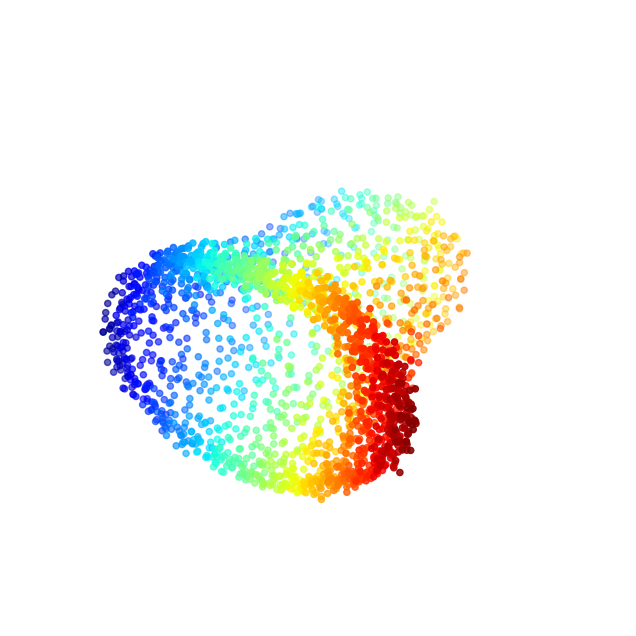

In [24]:
pts_vis = pts3d.squeeze().cpu().numpy()
pts_img = misc.get_ptcloud_img(pts_vis,30,30)

In [25]:
recon_pts, visible_pts, _= base_model(pts3d, vis=True)

group size:  32
input point cloud shape:  torch.Size([1, 2048, 3])
original center chape:  torch.Size([1, 64, 3])
center[~mask] and center[mask] torch.Size([64, 3]) torch.Size([0, 3])
x_vis shape:  torch.Size([1, 64, 384])
mask token shape:  torch.Size([1, 0, 384])
x full shape:  torch.Size([1, 64, 384])
x_rec shape:  torch.Size([1, 64, 384])
rebuild point and gt point shape:  torch.Size([64, 32, 3]) torch.Size([64, 0, 3])
output shape:  torch.Size([1, 2048, 3]) torch.Size([1, 2048, 3]) torch.Size([1, 64, 3])


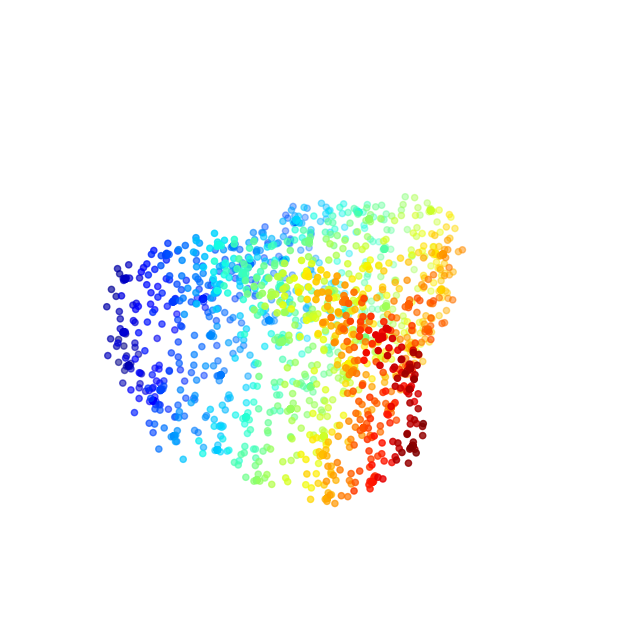

In [26]:
recon_pts_img = misc.get_ptcloud_img(recon_pts.squeeze().detach().cpu().numpy(),30,30)